## School project - 5MLRE
The following notebook was created for a school project to create an anime recommendation system. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- AMIMI Lamine
- BEZIN Théo
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. **Data analysis (you are here)**
2. Data preprocessing
3. Collaborative filtering
4. Content-based filtering
5. _Appendix_

# 1 - Data analysis
The purpose of this first notebook will be to analyze the data and draw graphs to better understand the dataset before going further.

### Index
<ol type="A">
  <li>The dataset</li>
  <li>Notebook initialization</li>
  <li>Data exploration</li>
  <li>Conclusion of the data analysis</li>
</ol>

## A - The dataset
This project will use a dataset extracted from the [MyAnimeList](https://myanimelist.net/) website. The dataset is actually composed of two datasets which we will explain below.

### A.1 - The anime dataset
This first dataset contains 12,294 animes with the following data:
- **anime_id:** The [MyAnimeList](https://myanimelist.net/) unique identifier.
- **name:** The full name of the anime.
- **genre:** A comma-separated list of the genres of this anime.
- **type:** The type of media of the anime (movie, TV, OVA, ...).
- **episodes:** How many episodes this anime has. It is set at `1` if the anime type is `movie`.
- **rating:** The average rating out of ten for this anime.
- **members:** Number of community members that are in this anime's group.

### A.2 - The rating dataset
The second dataset is the list of user ratings made for the anime in the previous dataset.
- **user_id :** A randomly generated non-identifiable identifier.
- **anime_id:** The [MyAnimeList](https://myanimelist.net/) unique identifier.
- **rating:** The rating out of ten given by this user. If the user watched the anime but did not rate it, the rating is set to `-1`.

## B - Notebook initialization
The following code blocks will be replicated in the next notebooks. Their main purpose is to import the necessary packages, initialize some of them and define a bunch of constants and utility functions used in the project. A small explanation will be added to each block of code, but will then be omitted to avoid repetition.

### B.1 - Imports
Here we import all used packages. This prevents some imports from being hidden in another piece of code and ensures that nothing is imported twice.

In [3]:
# OS and filesystem
from pathlib import Path

# Data
import pandas
from matplotlib import pyplot
import matplotx

# Console output
from colorama import Fore, Style

### B.2 - Package initialization
We define the style of the graphs generated by the `matplotlib` package to facilitate quick identification of trends and patterns in the data and to effectively communicate the results.

In [4]:
pyplot.style.use(matplotx.styles.dracula)  # Set the matplotlib style

### B.3 - Constants
We also define some constants used in this notebook. If you clone this project, be careful when changing these constants and remember to apply the changes in all notebooks. You may notice that we have defined a random state. Although it is never used for final models, it is useful when we try to compare the performance of different models on the same dataset.

In [5]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Plots
FIG_SIZE = (12, 7)

# Misc.
RANDOM_STATE = 2077

### B.4 - Datasets loading
We then load the two provided datasets. We specify most of the dtypes to save time both in loading and preprocessing the data. You may notice that we set the type of the `episodes` column to `str`. This is because some rows in the dataset contain strings instead of integers. We will deal with this problem later.

In [6]:
data_anime = pandas.read_csv((DATA_FOLDER / "anime.csv"),
                             dtype={"anime_id": int, "name": str, "genre": str, "type": "category", "episodes": str, "rating": float, "members": int})
data_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [7]:
data_ratings = pandas.read_csv((DATA_FOLDER / "rating.csv"),
                               dtype={"user_id": int, "anime_id": int, "rating": float})
data_ratings

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0
...,...,...,...
7813732,73515,16512,7.0
7813733,73515,17187,9.0
7813734,73515,22145,10.0
7813735,73516,790,9.0


## C - Data exploration
We will now explore both datasets to understand what kind of data we will use in our future recommendation system.

### C.1 - Null and empty values
We begin this analysis by checking the rate of missing data in the dataset.

In [8]:
def missing_values(df, df_name: str = None, keep_zeros=True) -> None:
    data_count = df.shape[0] * df.shape[1]
    missing = missing_df = df.isna().sum()

    if not keep_zeros:
        missing_df = missing_df[missing_df > 0]

    missing_df = missing_df.sort_values(ascending=False).apply(lambda m: f"{m} ({round((m * 100) / df.shape[0], 2)}%)")

    df_name = f" ({df_name})" if df_name is not None else ""
    print((
        f"{Style.BRIGHT}Missing values{df_name}:{Style.RESET_ALL} {round((missing.sum() / data_count) * 100, 2)}%\n"
        f"{Style.DIM}{Fore.WHITE}{missing_df}{Style.RESET_ALL}"
    ))


missing_values(df=data_anime, df_name="Anime", keep_zeros=True)
print()  # Printing a new line
missing_values(df=data_ratings, df_name="Ratings", keep_zeros=True)

Missing values (Anime): 0.37%
rating      230 (1.87%)
genre         62 (0.5%)
type          25 (0.2%)
anime_id       0 (0.0%)
name           0 (0.0%)
episodes       0 (0.0%)
members        0 (0.0%)
dtype: object

Missing values (Ratings): 0.0%
user_id     0 (0.0%)
anime_id    0 (0.0%)
rating      0 (0.0%)
dtype: object


We notice that the `ratings` dataset is perfectly filled, but the `anime` dataset has missing ratings, genres and types.

### C.2 - Duplicated values
We then check if the datasets contains any duplicated rows.

In [9]:
def duplicated_values(df, df_name: str = None) -> None:
    data_count = df.shape[0] * df.shape[1]
    duplicated_count = df.duplicated().sum()
    duplicated = df[df.duplicated(keep=False)] if (duplicated_count > 0) else None

    df_name = f" ({df_name})" if df_name is not None else ""
    print(f"{Style.BRIGHT}Duplicated values{df_name}:{Style.RESET_ALL} {duplicated_count} ({round((duplicated_count.sum() / data_count) * 100, 2)}%)")
    if duplicated is not None:
        print(duplicated)


duplicated_values(df=data_anime, df_name="Anime")
print()  # Printing a new line
duplicated_values(df=data_ratings, df_name="Ratings")

Duplicated values (Anime): 0 (0.0%)

Duplicated values (Ratings): 1 (0.0%)
         user_id  anime_id  rating
4499258    42653     16498     8.0
4499316    42653     16498     8.0


The `anime` dataset seems to have no duplicated rows, but the `ratings` dataset has two rating with the same `user_id`, `anime_id` and `rating`. It is not much, but it may be a good idea to remove this duplicate during the data preprocessing.

### C.3 - Frequency of anime based on the media type
**TODO: Add text**

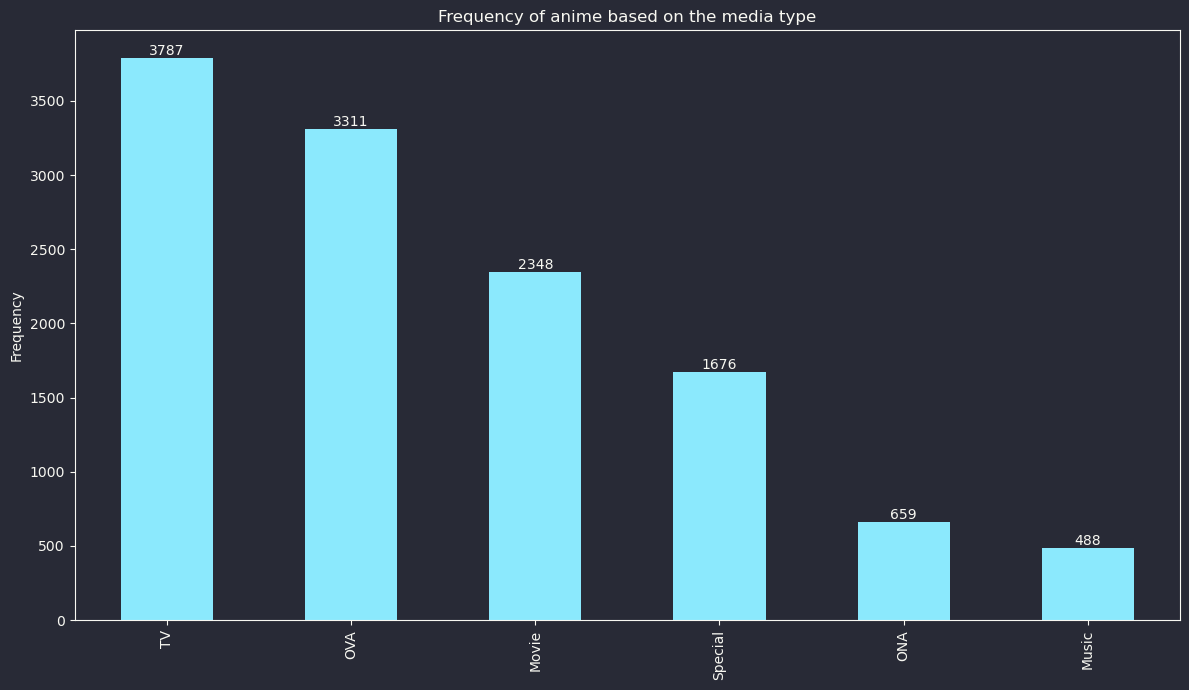

In [10]:
ax = data_anime["type"].value_counts().plot(kind="bar", figsize=FIG_SIZE)
pyplot.title("Frequency of anime based on the media type")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge")
pyplot.tight_layout()
pyplot.show()

**TODO: Add text**

### C.4 - Frequency of anime per genre
Since an anime can have several genres, we start by splitting the `genre` column to count each individual genre of an anime.

In [11]:
genres_count = data_anime["genre"].str.split(", ").explode("genre").value_counts()

We can now plot the resulting data set in a more readable graph.

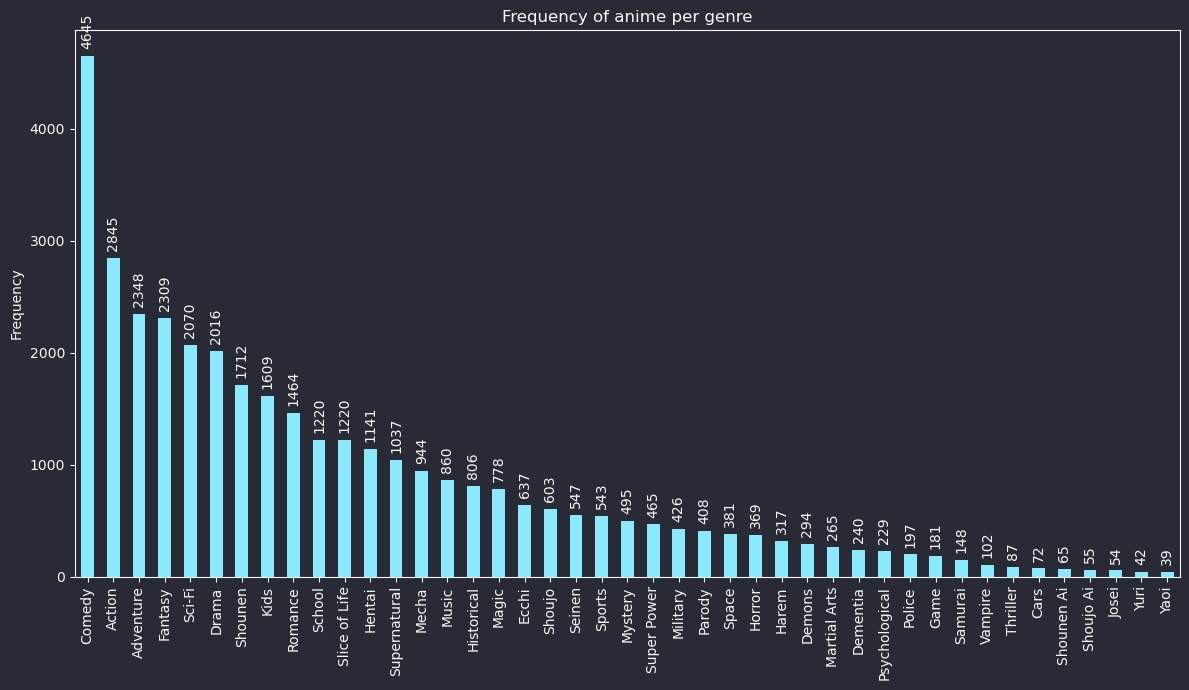

In [12]:
ax = genres_count.plot(kind="bar", figsize=FIG_SIZE)
pyplot.title("Frequency of anime per genre")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge", rotation="vertical", padding=5)
pyplot.tight_layout()
pyplot.show()

**TODO: Add text**

### C.5 - Box plot of rating by genre
In order to obtain a rating by genre for each of the anime, we first divide the genres of each of the anime in the dataset. These genres are then divided into as many new rows as necessary and the anime's rating is added next to the genre of that same anime. In this way, we end up with a new dataset with a list of genres and a note associated with each of them.

In [13]:
genres_rating = data_anime.copy()[["genre", "rating"]]
genres_rating["genre"] = genres_rating["genre"].str.split(", ")
genres_rating = genres_rating.set_index(["rating"]).apply(pandas.Series.explode).reset_index()
genres_rating

,rating,genre
0,9.37,Drama
1,9.37,Romance
2,9.37,School
3,9.37,Supernatural
4,9.26,Action
...,...,...
36342,4.15,Hentai
36343,4.28,Hentai
36344,4.88,Hentai
36345,4.98,Hentai


**TODO: Add text**

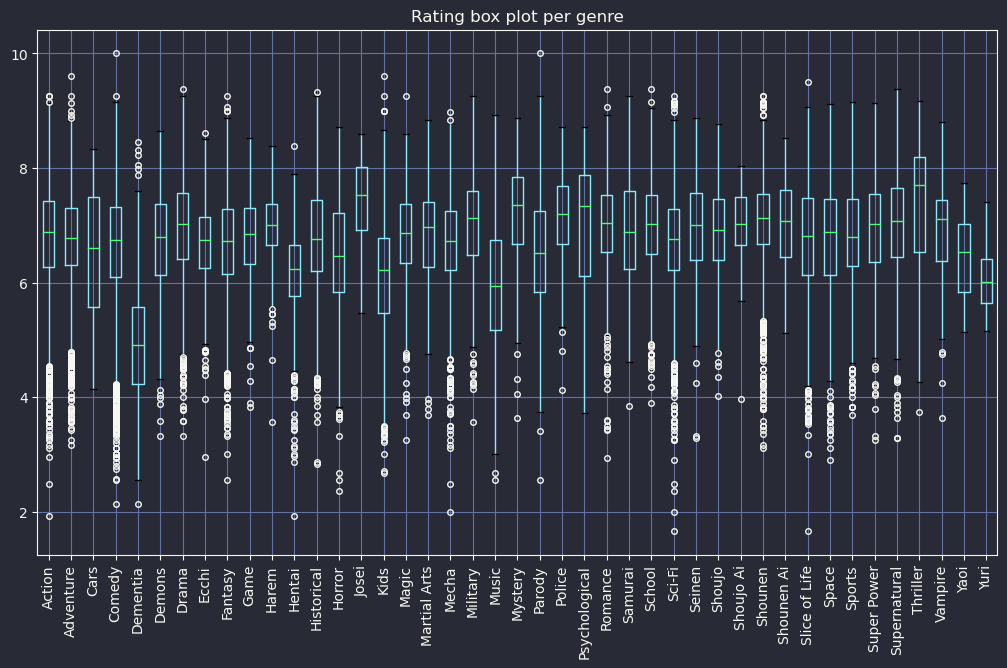

In [14]:
fig, ax = pyplot.subplots(figsize=FIG_SIZE)
genres_rating.boxplot(column=["rating"], by="genre", rot=90, flierprops={"markersize": 4}, ax=ax)
pyplot.title("Rating box plot per genre")
pyplot.suptitle("")
pyplot.xlabel("")
pyplot.show()

**TODO: Add text**

### C.6 - Frequency of rating values
**TODO: Add text**

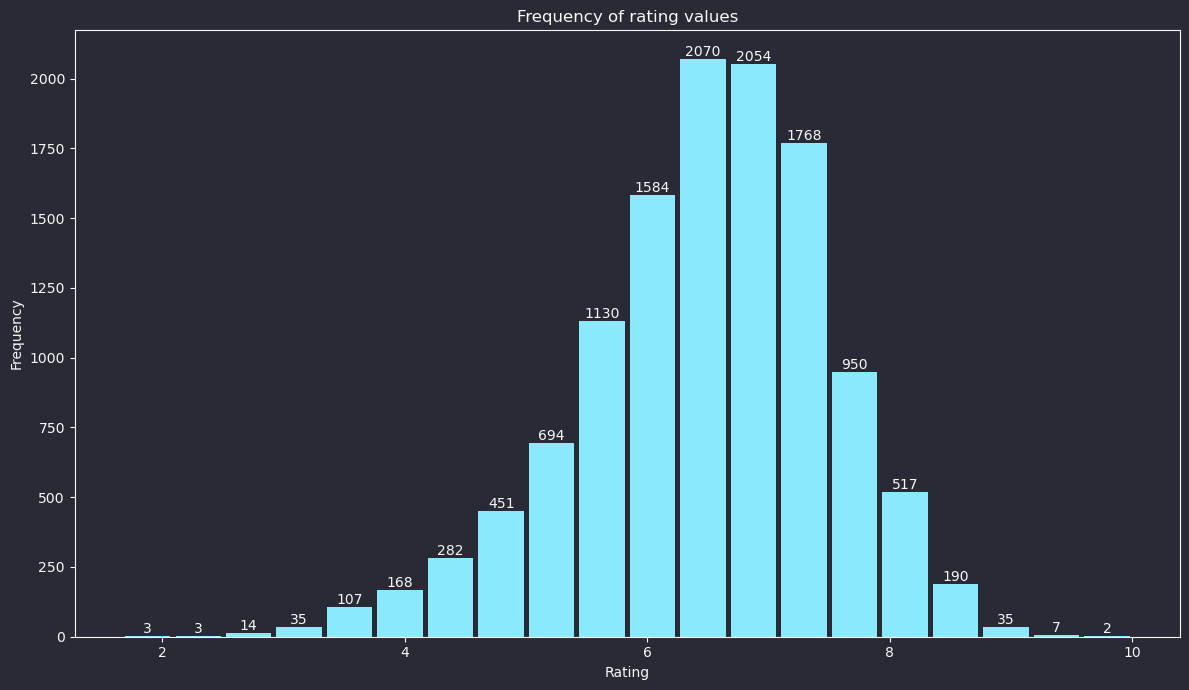

In [15]:
ax = data_anime["rating"].plot(kind="hist", bins=20, figsize=FIG_SIZE, rwidth=0.9)
pyplot.title("Frequency of rating values")
pyplot.xlabel("Rating")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge")
pyplot.tight_layout()
pyplot.show()

**TODO: Add text**

### C.7 - Frequency of the number of rating
**TODO: Add text**

In [17]:
ratings_count_per_anime = data_ratings.groupby(["anime_id"]).size().reset_index(name="num_ratings")
ratings_count_per_anime

,anime_id,num_ratings
0,1,15509
1,5,6927
2,6,11077
3,7,2629
4,8,413
...,...,...
11195,34367,5
11196,34412,1
11197,34475,4
11198,34476,1


**TODO: Add text**

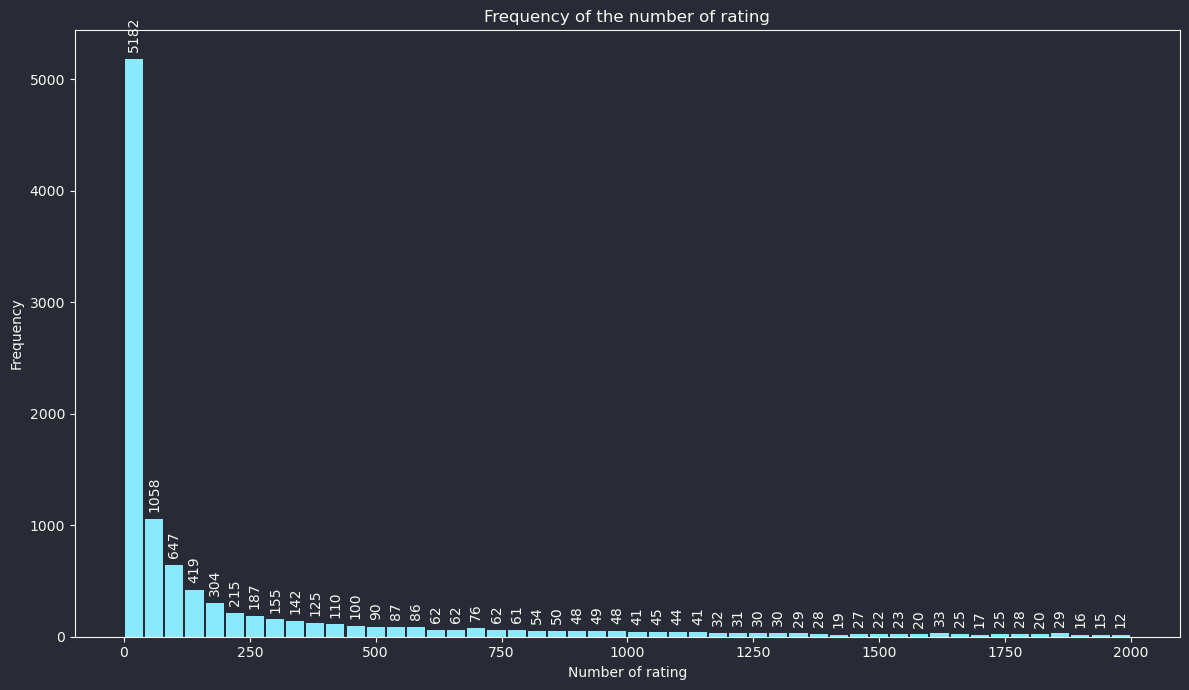

In [18]:
ax = ratings_count_per_anime["num_ratings"].plot(kind="hist", bins=50, range=(0, 2000), figsize=FIG_SIZE, rwidth=0.9)
pyplot.title("Frequency of the number of rating")
pyplot.xlabel("Number of rating")
pyplot.ylabel("Frequency")
ax.bar_label(ax.containers[0], label_type="edge", rotation="vertical", padding=5)
pyplot.tight_layout()
pyplot.show()

**TODO: Add text**

### C.8 - Ranking by average rating
**TODO: Add text**

In [19]:
data_anime["rank_avg_rating"] = data_anime["rating"].rank(method="average", ascending=False)
data_anime.sort_values(by="rank_avg_rating", ascending=True).head(n=10)

,anime_id,name,genre,type,episodes,rating,members,rank_avg_rating
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13,1.0
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,Unknown,9.60,47,2.0
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62,3.0
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4.0
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44,5.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,6.0
10786,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",OVA,1,9.25,53,7.5
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7.5
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,10.0


**TODO: Add text**

### C.9 - Ranking by number of rating
**TODO: Add text**

In [20]:
data_anime = data_anime.merge(ratings_count_per_anime, how="left", on="anime_id")
data_anime["num_ratings"] = data_anime["num_ratings"].fillna(0).astype(int)
data_anime

,anime_id,name,genre,type,episodes,rating,members,rank_avg_rating,num_ratings
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4.0,2199
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,6.0,24574
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7.5,1386
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.0,19283
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,10.0,3673
...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,11742.0,4
12290,5543,Under World,Hentai,OVA,1,4.28,183,11661.0,4
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,11187.5,3
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,11085.5,4


**TODO: Add text**

In [21]:
data_anime["rank_num_ratings"] = data_anime["num_ratings"].rank(method="average", ascending=False)
data_anime.sort_values(by="rank_num_ratings", ascending=True).head(n=10)

,anime_id,name,genre,type,episodes,rating,members,rank_avg_rating,num_ratings,rank_num_ratings
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,53.5,39340,1.0
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100,899.5,30583,2.0
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229,106.0,29584,3.0
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,32.0,27718,4.0
760,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511,864.5,27506,5.0
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796,197.5,27183,6.0
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,937.0,25925,7.0
200,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384,243.5,25032,8.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,6.0,24574,9.0
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817,160.5,24283,10.0
